In [ ]:
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom
%pylab inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [ ]:
height , width = 512 , 512 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'images', 'table_mask')
  # cell_path = tf.strings.regex_replace(file_path, 'FinTabNet_data', 'cell_mask')

  # table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  # cell_path = tf.strings.regex_replace(cell_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.image.resize(images , [height,width])
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  # #reading  , resizing and normalizing for cell mask data
  # cell_mask = tf.io.read_file(cell_path)
  # cell_mask = tf.image.decode_jpeg(cell_mask, channels=1) 
  # cell_mask = tf.image.resize(cell_mask, [height, width]) 
  # cell_mask = tf.cast(cell_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask,
                  # "cell_mask" : cell_mask 
                  }

def data_pipeline(dataset, input , batch_size = 1):
  #how many parallel call need to be done , so left tensor to decide
  autotune = tf.data.experimental.AUTOTUNE

  # autotune = 1
  # print(autotune)
  total_size = len(list(dataset))
  dataset = dataset.take(int(total_size))
  dataset = dataset.shuffle(total_size)
  if input == 'train':
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train 
    proportion = 1
    input_data_size = int(proportion * total_size)
    print(input_data_size)
    
    #fetching data for input
    input_data = dataset.take(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    train_data = input_data

    #kepping track of inital loaded data in the memory to speed up the the process for next iteration 
    input_data = input_data.cache()

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size # randomly samples elements from this buffer, replacing the selected elements with new elements
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    # to re-initialize the input_data
    input_data = input_data.repeat()

    #delivers data for the next step before the current step has finished
    input_data = input_data.prefetch(buffer_size=autotune)

    return input_data , train_data

  else:
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train and test
    proportion = 0.001
    input_data_size = int(proportion * total_size)
    print(input_data_size)
    
    #fetching data for input
    input_data = dataset.skip(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    test_data = input_data

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size 
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    return input_data , test_data

In [ ]:
#Create a source dataset from given  input data
#dataset = tf.data.Dataset.list_files("/content/content/Shareddrives/my_drive/input/CHK1/data/marmots_1024/*.jpeg")
dataset = tf.data.Dataset.list_files("/content/drive/MyDrive/Fintab/Fintab_test_data/images/*.jpg")

# train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1)

5


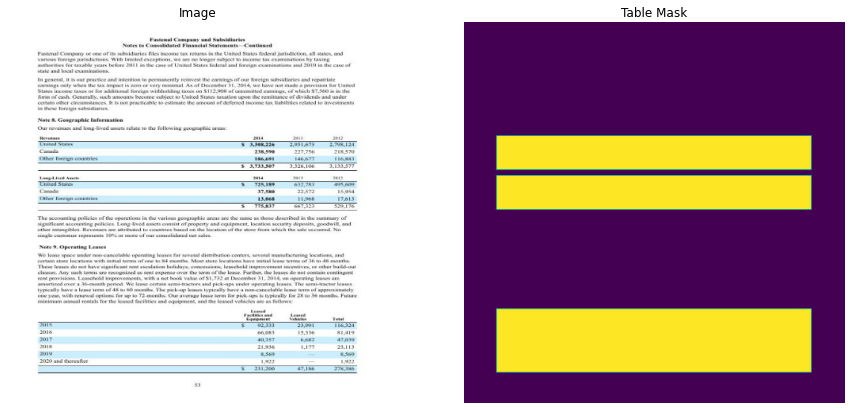

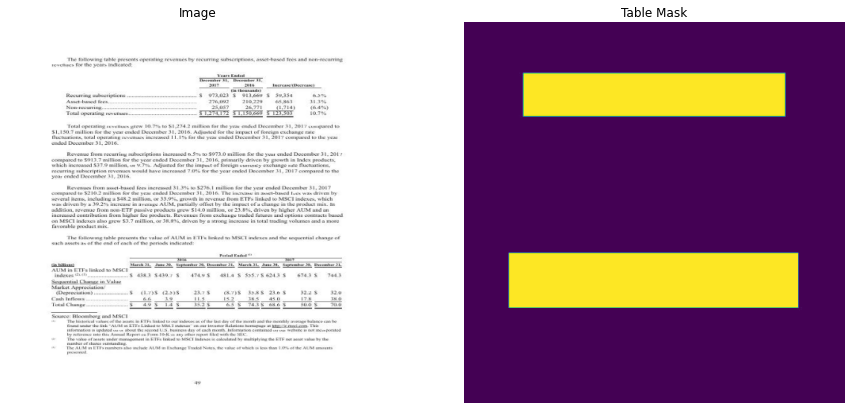

In [ ]:
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  lists = [image, mask['table_mask'], 
          #  mask['cell_mask']
           ]
  title = ['Image', 'Table Mask',
          #  'cell Mask'
           ]         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()   

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Fintab/table 11-25 exp2 512x512 96.3/mymodel_best')

In [ ]:
def masks(table_mask):
  table_mask = tf.argmax(table_mask, axis=-1)
  table_mask = table_mask[..., tf.newaxis]


  # cell_mask = tf.argmax(cell_mask, axis=-1)
  # cell_mask = cell_mask[..., tf.newaxis]
  return table_mask[0]  #, cell_mask[0]

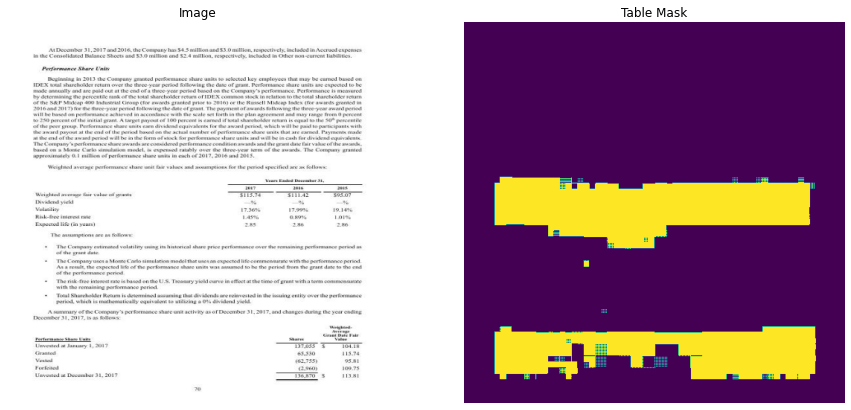

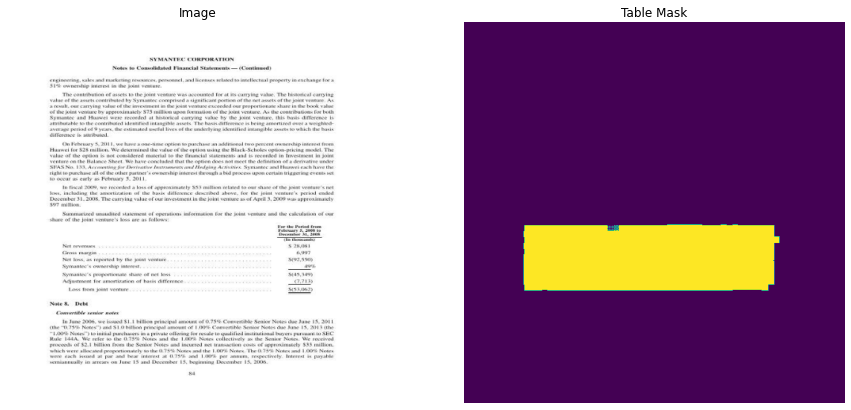

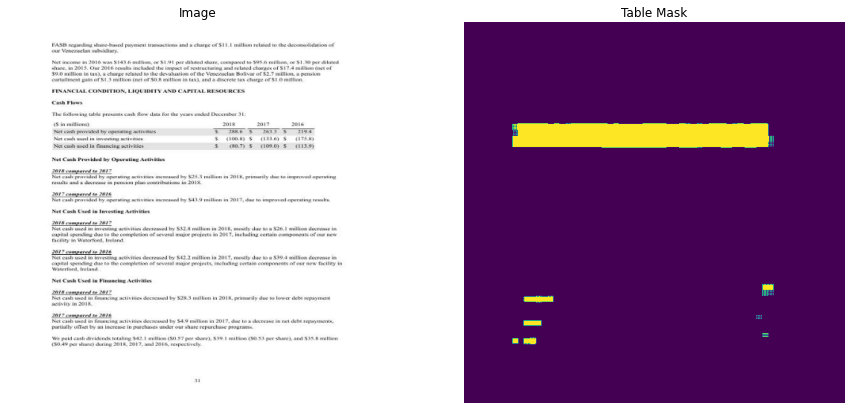

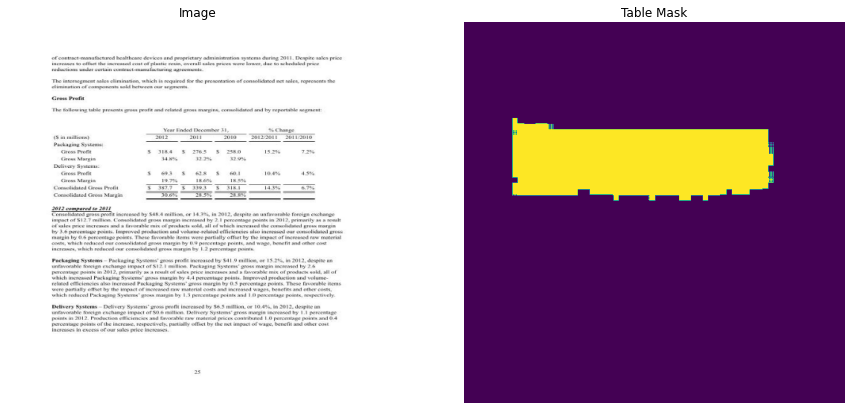

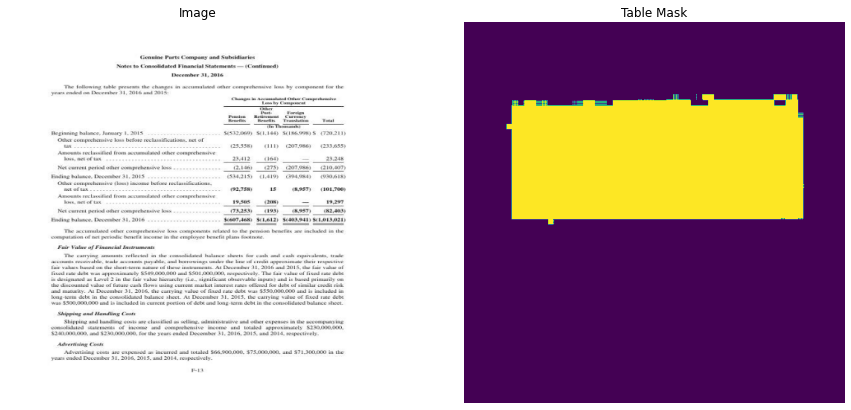

In [ ]:
import numpy as np
number = 5
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  mask1= model.predict(image[np.newaxis,:,:,:])
  table_mask= masks(mask1)

  lists = [image, table_mask]
  title = ['Image', 'Table Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()

In [7]:
import numpy as np
table = list()
predicted_table = list()
for image, mask  in tqdm(test_data):
  table.append(mask['table_mask'])
  # column.append(mask['column_mask'])
  mask1_ = model.predict(image[np.newaxis,:,:,:])
  table_mask = masks(mask1_)
  predicted_table.append(table_mask)
  # predicted_column.append(column_mask)

100%|██████████| 5768/5768 [1:40:58<00:00,  1.05s/it]


In [8]:
# #https://www.tensorflow.org/api_docs/python/tf/keras/metrics
def recall(table, predicted_table):
  m = tf.keras.metrics.Recall()
  m.update_state(table, predicted_table)
  return m.result().numpy()

def precision(table, predicted_table):
  m = tf.keras.metrics.Precision()
  m.update_state(table, predicted_table)
  return m.result().numpy()  

def result(true , pred):
  Recall = recall(true, pred)
  Precision = precision(true, pred)
  f1 = 2*(Recall * Precision)/(Recall + Precision)
  print(f'Recall is {Recall}')
  print("-"*50)
  print(f'Precision is {Precision}')
  print("-"*50)
  print(f'f1_score is {f1}')

In [9]:
#checking for table mask
result(table , predicted_table)

Recall is 0.8717299699783325
--------------------------------------------------
Precision is 0.937411367893219
--------------------------------------------------
f1_score is 0.9033783736590333


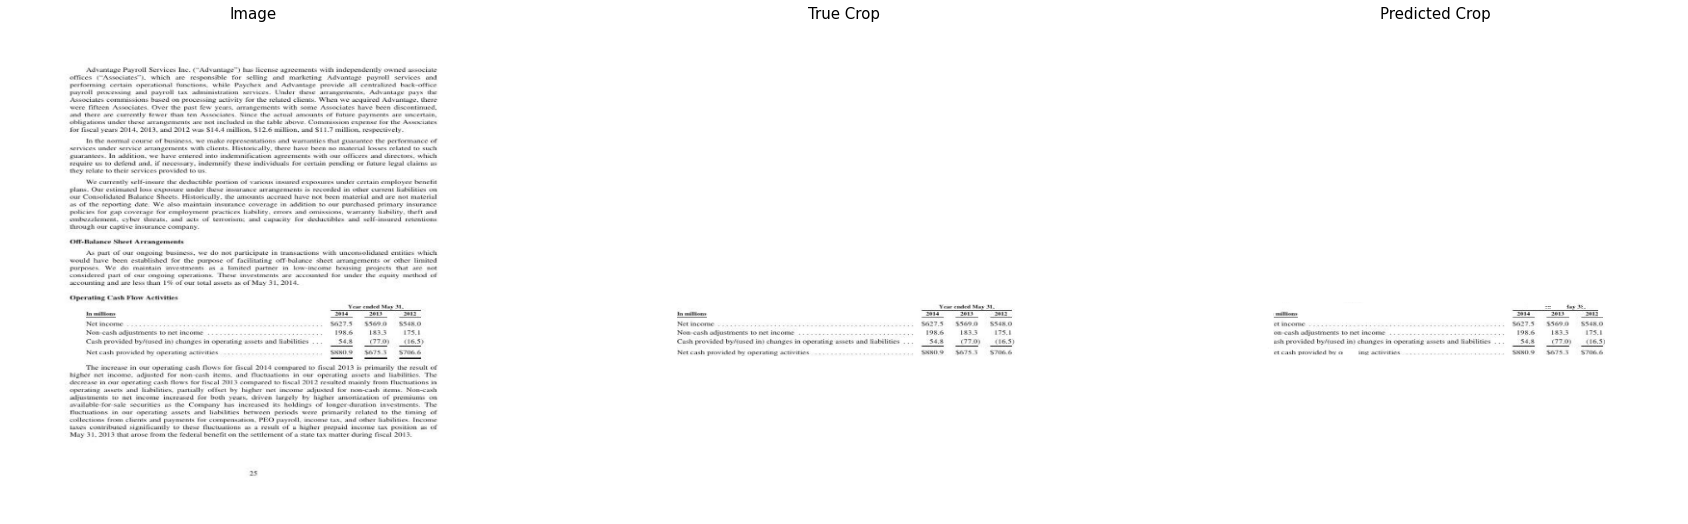

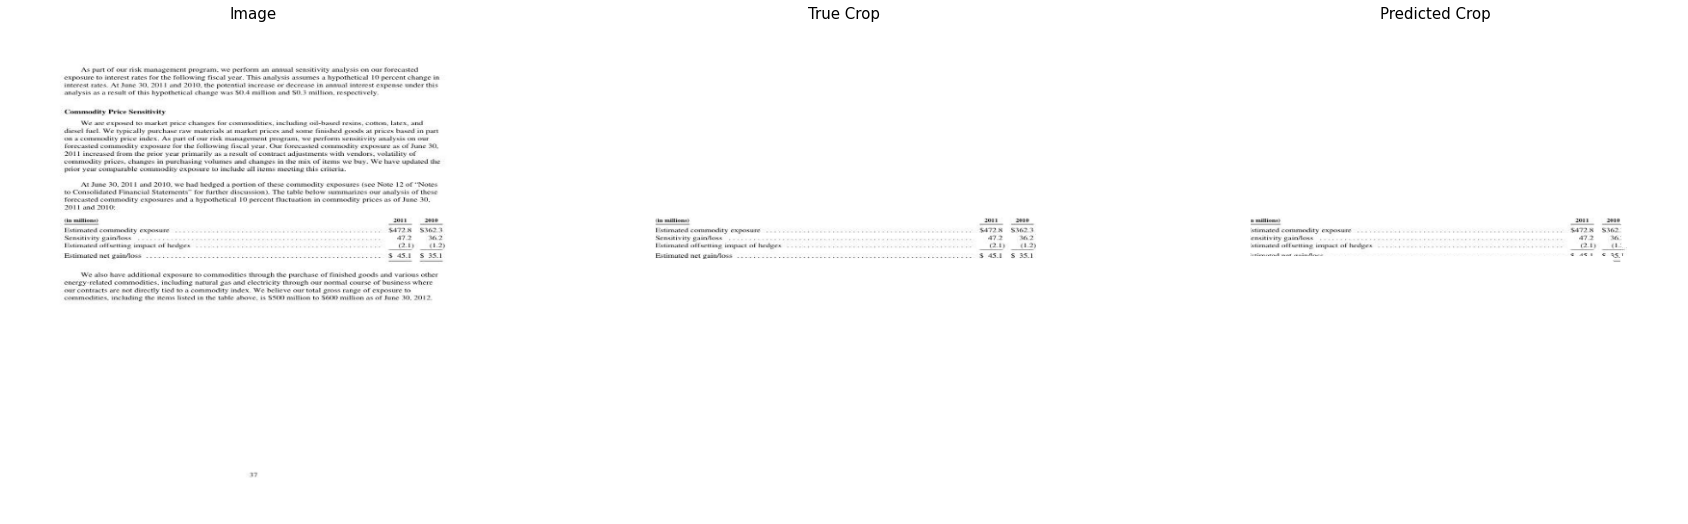

In [ ]:
#randomly comparing predicted output with actual output
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(30, 50))

  true_table = mask['table_mask']
  true_table=tf.keras.preprocessing.image.array_to_img(true_table)
  true_table = true_table.convert('L')

  # true_column = mask['column_mask']
  # true_column=tf.keras.preprocessing.image.array_to_img(true_column)
  # true_column = true_column.convert('L')


  mask1 = model.predict(image[np.newaxis,:,:,:])
  table_mask = masks(mask1)

  pred_table = tf.keras.preprocessing.image.array_to_img(table_mask)
  # pred_column = tf.keras.preprocessing.image.array_to_img(column_mask)
  pred_table = pred_table.convert('L')
  # pred_column = pred_column.convert('L')


  title = ['Image', 'True Crop', 'Predicted Crop']         
  for i in range(len(title)): 
    plt.subplot(1, len(title), i+1)
    if i == 0:
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
      plt.axis('off')

    elif i == 1:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(true_table)
      #img.putalpha(true_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
      plt.axis('off')

    else:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(pred_table)
      #img.putalpha(pred_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))  
      plt.axis('off')
  plt.show() 

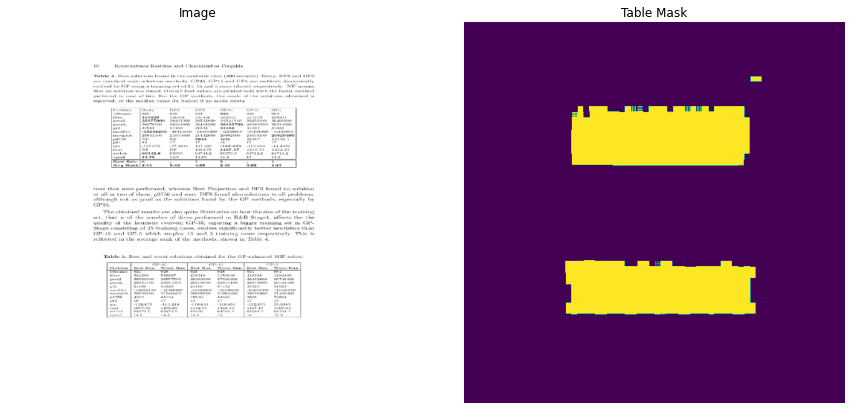

In [ ]:
file_path = '/content/drive/MyDrive/Fintab/testing data/10.1.1.1.2_10.bmp'
image = tf.io.read_file(file_path)
image = tf.image.decode_bmp(image, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
image = tf.image.resize(image , [height,width])
image = tf.cast(image, tf.float32) / 255.0 # normalizing image

plt.figure(figsize=(15, 15))
mask1= model.predict(image[np.newaxis,:,:,:])
table_mask= masks(mask1)

lists = [image, table_mask]
title = ['Image', 'Table Mask']         
for i in range(len(lists)):
  plt.subplot(1, len(lists), i+1)
  plt.title(title[i])
  plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
  plt.axis('off')
plt.show()